In [1]:
import numpy as np
import json, os
from phc import module_reload, json_file_readable
import matplotlib.pyplot as plt

INDEX_DIR = '/nfs/dust/ilc/user/bliewert/zhh/CreateRawIndex/v1'
CHUNK_DIR = '/nfs/dust/ilc/user/bliewert/zhh/CreatePreselectionChunks/v1'
DATA_ROOT = '/nfs/dust/ilc/user/bliewert/zhh/PreselectionFinal/v1'
DATA_ROOT_RUNTIME = '/nfs/dust/ilc/user/bliewert/zhh/PreselectionRuntime/v1'
REPO_ROOT = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH' if os.name != 'nt' else 'C:/DevRepositories/ZHH'

processes = np.load(f'{INDEX_DIR}/processes.npy')
samples = np.load(f'{INDEX_DIR}/samples.npy')
existing_chunks = np.load(f'{CHUNK_DIR}/chunks.npy')

print(len(existing_chunks))

4404


In [79]:
(existing_chunks['process'] == 'qqqqh').sum()

250

In [80]:
existing_chunks['branch'][existing_chunks['process'] == 'qqqqh']

array([2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531,
       2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542,
       2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553,
       2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564,
       2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575,
       2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586,
       2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597,
       2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608,
       2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619,
       2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630,
       2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641,
       2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652,
       2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663,
       2664, 2665, 2666, 2667, 2668, 2669, 2670, 26

In [3]:
module_reload('zhh')
from zhh import get_adjusted_time_per_event, get_runtime_analysis, \
    get_process_normalization, get_sample_chunk_splits, \
    get_chunks_factual

if True:
    runtime_analysis = get_runtime_analysis(DATA_ROOT_RUNTIME)
    pn = get_process_normalization(processes, samples, RATIO_BY_EXPECT=1.)
    atpe = get_adjusted_time_per_event(runtime_analysis)
else:
    runtime_analysis = np.load(f'{CHUNK_DIR}/runtime_analysis.npy')
    pn = np.load(f'{CHUNK_DIR}/process_normalization.npy')
    atpe = np.load(f'{CHUNK_DIR}/v1/atpe.npy')

with open(f'/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/workflows/analysis/custom_statistics.json', 'r') as file:
    custom_statistics = json.load(file)
    
new_chunks = get_sample_chunk_splits(samples, atpe, pn, custom_statistics=custom_statistics, MAXIMUM_TIME_PER_JOB=7200)

In [4]:
len(existing_chunks), len(new_chunks)

(4404, 4404)

In [6]:
from zhh import get_chunks_factual
chunks_f = get_chunks_factual(DATA_ROOT, existing_chunks, attach_time=True)
np.save(f'{REPO_ROOT}/chunks_f.npy', chunks_f)

# (actual) Runtime analysis

In [7]:
runtime_analysis_2 = get_runtime_analysis(chunks_factual=chunks_f)
pn = get_process_normalization(processes, samples, RATIO_BY_EXPECT=1.)
atpe_2 = get_adjusted_time_per_event(runtime_analysis_2)

with open(f'/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/workflows/analysis/custom_statistics.json', 'r') as file:
    custom_statistics = json.load(file)
    
better_chunks = get_sample_chunk_splits(samples, atpe_2, pn, custom_statistics=custom_statistics, MAXIMUM_TIME_PER_JOB=7200)

In [8]:
len(existing_chunks), len(better_chunks)

(4404, 4665)

In [18]:
selected = np.argsort(-atpe_2['tPE'])[:8]
selected_processes = atpe_2['process'][selected]

tPE_runtime = np.zeros(len(selected))
tPE_better = atpe_2['tPE'][selected]

for i, p in enumerate(selected_processes):
    tPE_runtime[i] = (atpe['tPE'][atpe['process'] == p])

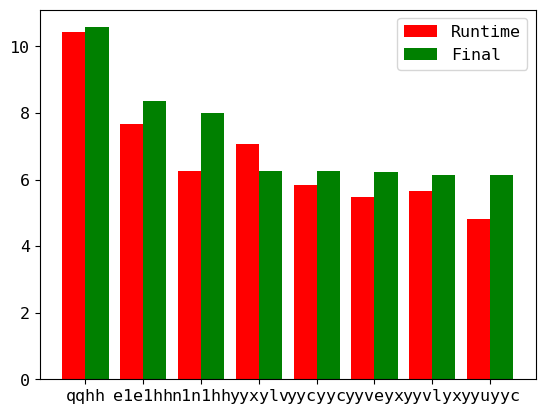

In [19]:
fig, ax = plt.subplots()

X_axis = np.arange(len(selected_processes)) 

ax.bar(X_axis - 0.2, tPE_runtime, 0.4, color='r', align='center', label='Runtime')
ax.bar(X_axis + 0.2, tPE_better, 0.4, color='g', align='center', label='Final')

ax.set_xticks(X_axis, selected_processes)
plt.legend()

plt.show()

<BarContainer object of 10 artists>

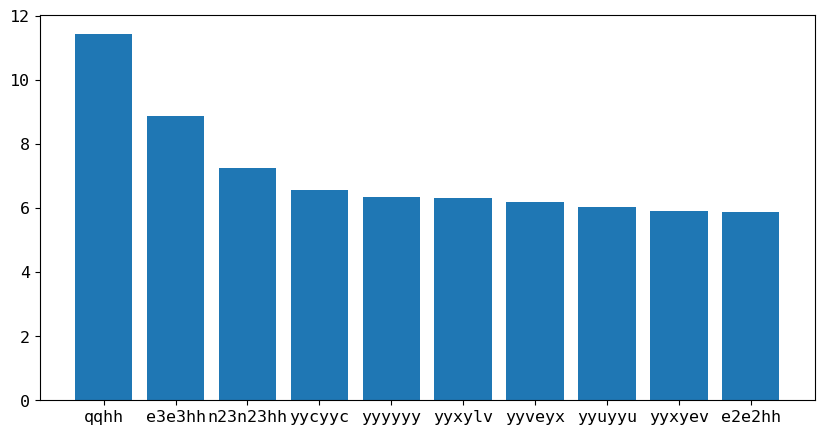

In [84]:
unq_processes = np.unique(chunks_f['process'])
result = np.zeros(len(unq_processes), dtype=[('process', 'U10'), ('tPE', 'f4')])

for i, process in enumerate(unq_processes):
    chunks = chunks_f[chunks_f['process'] == process]
    
    result['process'][i] = process
    result['tPE'][i] = chunks['runtime'].sum() / chunks['chunk_size_factual'].sum()

sorting = np.argsort(-result['tPE'])
n_show = 10

plt.subplots(figsize=(10, 5))
plt.bar(unq_processes[sorting][:n_show], result['tPE'][sorting][:n_show])

In [73]:
result['tPE'][result['process'] == 'qqqqh']

array([5.2942], dtype=float32)

# Comparison to assumptions

<BarContainer object of 10 artists>

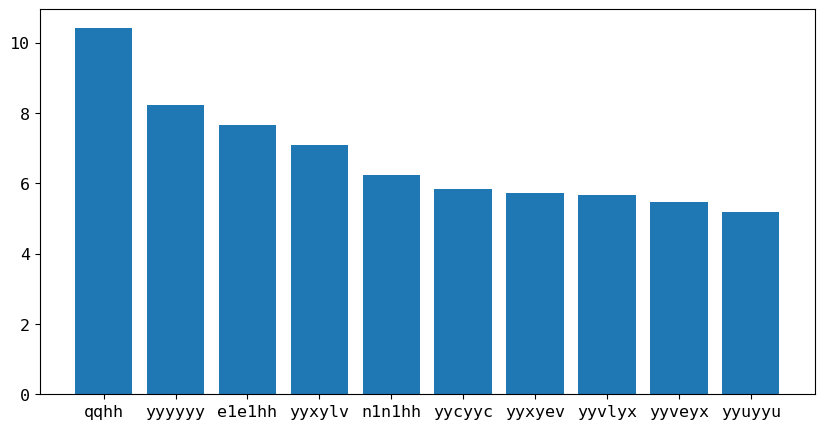

In [85]:
sorting = np.argsort(-atpe['tPE'])

plt.subplots(figsize=(10, 5))
plt.bar(atpe['process'][sorting][:n_show], atpe['tPE'][sorting][:n_show])

In [86]:
atpe['tPE'][result['process'] == 'qqqqh']

array([2.97], dtype=float32)

['llllll' 'vvveev' 'vvvlev' 'eeeeee' 'vvvelv' 'llvlev' 'eeeeee' 'llvelv'
 'vvveev' 'xxvelv' 'vvxyev' 'llvllv' 'eeveev' 'llvlyx' 'eevelv' 'vvvllv'
 'vvveev' 'llllll' 'eeeell' 'llxyyx']


(array([4.267e+03, 1.170e+02, 1.000e+01, 2.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([ 0.09151225,  1.90054282,  3.7095734 ,  5.51860398,  7.32763455,
         9.13666513, 10.9456957 , 12.75472628, 14.56375686, 16.37278743,
        18.18181801]),
 <BarContainer object of 10 artists>)

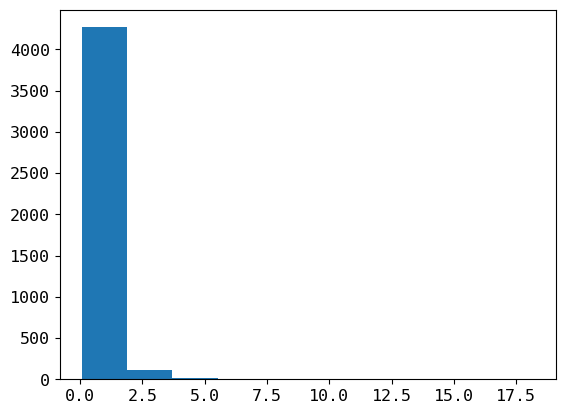

In [87]:
fractions = np.zeros(len(chunks_f), dtype=float)
for i, chunk in enumerate(chunks_f):
    fractions[i] = (chunk['runtime'] / chunk['chunk_size_factual'])/atpe['tPE'][atpe['process'] == chunk['process']]
    
sorting = np.argsort(-fractions)
print(chunks_f['process'][sorting][:20])

plt.hist(fractions)

(array([  70., 1605.,   66.,   37.,    9., 1753.,   75.,  125.,   58.,
         606.]),
 array([0.98842258, 0.98958032, 0.99073806, 0.9918958 , 0.99305355,
        0.99421129, 0.99536903, 0.99652677, 0.99768452, 0.99884226,
        1.        ]),
 <BarContainer object of 10 artists>)

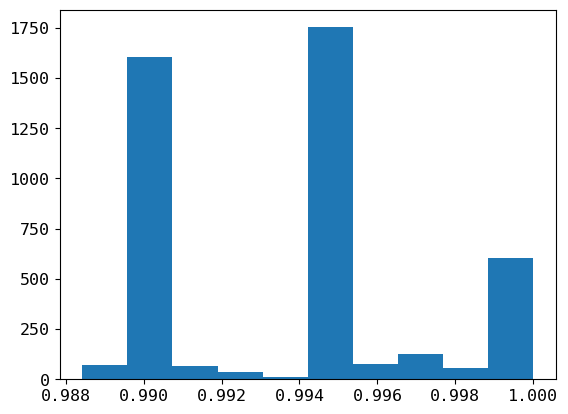

In [88]:
plt.hist(chunks_f['chunk_size_factual']/chunks_f['chunk_size'])

In [17]:
print(existing_chunks[2548])

atpe['tPE'][atpe['process'] == 'qqqqh'][0] * existing_chunks['chunk_size'][2548]

(2548, 'qqqqh', 'qqqqh_LR', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015747/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403019.Pqqqqh.eL.pR.n001.d_dstm_15747_13.slcio', 27, 2424, 2424)


7199.280069351196

In [4]:
hh = list(filter(lambda x: 'hh' in x, np.unique(chunks['process'])))

for process in hh:
    print(pn[pn['process'] == process])

[('e1e1hh', 'e1e1hh_LL', 0.00027244, 1.8007195e-07, 953154,  0.1716363 , 1)
 ('e1e1hh', 'e1e1hh_LR', 0.01141446, 1.4011289e-05, 953154, 13.354916  , 3)
 ('e1e1hh', 'e1e1hh_RL', 0.00724756, 5.3226370e-07, 953154,  0.5073292 , 1)
 ('e1e1hh', 'e1e1hh_RR', 0.00027244, 3.7157957e-08, 953154,  0.03541726, 1)]
[('e2e2hh', 'e2e2hh_LR', 0.01116575, 2.7462776e-05, 475696, 13.063933 , 2)
 ('e2e2hh', 'e2e2hh_RL', 0.00714938, 1.0520512e-06, 475696,  0.5004566, 1)]
[('e3e3hh', 'e3e3hh_LR', 0.01114067, 2.8200320e-05, 462214, 13.034582  , 2)
 ('e3e3hh', 'e3e3hh_RL', 0.00713333, 1.0803079e-06, 462214,  0.49933344, 1)]
[('n1n1hh', 'n1n1hh_LR', 0.03004878, 7.1302115e-05, 493072, 35.157074 , 6)
 ('n1n1hh', 'n1n1hh_RL', 0.01413045, 2.0060588e-06, 493072,  0.9891315, 1)]
[('n23n23hh', 'n23n23hh_LR', 0.0441279 , 1.07372296e-04, 480847, 51.629646 , 8)
 ('n23n23hh', 'n23n23hh_RL', 0.02827151, 4.11566543e-06, 480847,  1.9790053, 1)]
[('qqhh', 'qqhh_LR', 0.22561218, 1.3198312e-04, 2000000, 263.96625 , 40)
 ('qqh

In [16]:
s = 0
for process in ['e1e1hh', 'e2e2hh', 'e3e3hh']:
    s += np.sum(pn['n_events_expected'][pn['process'] == process])

print(s)

41.16760444641113


In [5]:
hh = list(filter(lambda x: 'hh' in x, np.unique(chunks['process'])))

for process in hh:
    print(chunks[chunks['process'] == process])

[(16758, 'e1e1hh', 'e1e1hh_LL', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015744/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403021.Pe1e1hh.eL.pL.n001.d_dstm_15744_14.slcio', 0, 0, 1)
 (16759, 'e1e1hh', 'e1e1hh_LR', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015744/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403022.Pe1e1hh.eL.pR.n002.d_dstm_15744_26.slcio', 0, 0, 3)
 (16760, 'e1e1hh', 'e1e1hh_RL', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015744/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403023.Pe1e1hh.eR.pL.n000.d_dstm_15744_6.slcio', 0, 0, 1)
 (16761, 'e1e1hh', 'e1e1hh_RR', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015743/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403024.Pe1e1hh.eR.pR.n000.d_dstm_15743_2.slcio', 0, 0, 1)]
[(16766, 'e2e2hh', 'e2e2hh_LR

In [6]:
failing = 0
for sample in samples:
    loc = sample['location']
    n_events = sample['n_events']
    
    for entry in chunks[chunks['location'] == loc]:
        if entry['chunk_start'] + entry['chunk_size'] > n_events:
            failing += 1
            print(f"{entry['chunk_start'] + entry['chunk_size']} > {n_events}")
            
            #print(chunks[chunks['location'] == loc])
            #print(sample)
            #break
    else:
        continue
    break
            
print(f'n failing: {failing}')

n failing: 0


In [7]:
len(chunks)

21901

Check worflow results

In [2]:
chunks = np.load('/nfs/dust/ilc/user/bliewert/zhh/CreatePreselectionChunks/v1/chunks.npy')

In [4]:
chunks[chunks['process'] == 'e1e1hh']

array([(13488, 'e1e1hh', 'e1e1hh_LL', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015744/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403021.Pe1e1hh.eL.pL.n001.d_dstm_15744_14.slcio', 0, 0, 1),
       (13489, 'e1e1hh', 'e1e1hh_LR', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015744/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403022.Pe1e1hh.eL.pR.n002.d_dstm_15744_26.slcio', 0, 0, 1),
       (13490, 'e1e1hh', 'e1e1hh_RL', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015744/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403023.Pe1e1hh.eR.pL.n000.d_dstm_15744_6.slcio', 0, 0, 1),
       (13491, 'e1e1hh', 'e1e1hh_RR', '/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-merged/500-TDR_ws/hh/ILD_l5_o1_v02/v02-02-03/00015743/000/rv02-02-03.sv02-02-03.mILD_l5_o1_v02.E500-TDR_ws.I403024.Pe1e1hh.eR.pR.n000.d_dstm_15743_2.slcio', 0, 0, 1)],
 

In [6]:
len(chunks)

15497

In [ ]:
len(chunks)

15497